In [1]:
%pylab inline
import pandas as pd
pd.set_option('display.precision', 5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plotEffect(df,margin=0.5):
    fig,axes = plt.subplots(1,df.index.size,sharey=True)
    fig.set_size_inches(df.index.size*1.5,2)
    for i in arange(df.index.size):
        ax = axes[i]
        ax.plot(df.columns,df.ix[i,:],'o-')
        ax.set_xlim(0.7,3.3)
        ax.set_ylim(df.min().min()-margin,df.max().max()+margin)
        ax.set_title(df.index[i])
        ax.set_xticks([1,2,3])
    print "\n効果図"
    plt.tight_layout()
    plt.show()

In [3]:
# 動特性の２乗和分解
def dynamicProp(M,A, calcSN=False, calcS=False, calcB=False, calcStandardSN=False):
    # Degree of Freedom
    Ft = len(A.index)*len(A.columns)
    Fb = 1
    Fnb = len(A.index) - 1
    Fe = Ft - Fb - Fnb
    Fn = Fnb + Fe
    # Squared Sum
    St = (A*A).sum().sum() #eq(4.7)
    L = np.asarray(A).dot(M) # A[3,3]とM[3,1]の行列積[3,1]
    r = (M*M).sum()
    Sb = (L.sum())**2/len(A.index)/r #eq(4.8)
    Snb = (L*L).sum()/r - Sb #eq(4.9)
    Se = St - Sb - Snb
    Sn = Snb + Se
    # Variance
    Vb = Sb/Fb
    Vnb = Snb/Fnb
    Ve = Se/Fe
    Vn = Sn/Fn
    
    # calcSNratio[db]
    if calcSN==True:
        eta = (1./len(A.index)/r*(Sb-Ve))/Vn #eq(4.15)
        return 10*np.log10(eta)
    
    # calc Standard SN ratio[db]
    if calcStandardSN==True:
        eta = (Sb-Ve)/Vn #eq(7.8)
        return 10*np.log10(eta)
    
    # calcS[db]
    if calcS==True:
        S = (1./len(A.index)/r*(Sb-Ve))
        return 10*np.log10(S)
    
    # calcB
    if calcB==True:
        beta = L.mean()/r
        return beta
    
    # PrintTable
    data = {'F': [Fb,Fnb,Fe,Fn,Ft], 'S':[Sb,Snb,Se,Sn,St], 'V':[Vb,Vnb,Ve,Vn,nan]}
    df = pd.DataFrame(data=data, index=["b","N*b","e","(N)","T"])
    print df

## 4ヶ月目 - 問1
>応答高速性が要求されるある制御回路では、電流急変速度
$$M_1=100, M_2=200, M_3=300 (A/\mu{s})$$
に対する出力変動yの目標値mは
$$m_1=0, M_2=50, M_3=67 (mV)$$
である。パラメータ設計のために6個の回路素子A,B,C,D,E,Fを各3水準にとり、<br>
直交表$L_{18}$の3~8列にわりつけ、$L_{18}$の各条件で3水準の信号に対する出力電圧変動yを
$$N_1=負側最悪条件, N_0=標準条件, N_2=正側最悪条件$$
で回路シミュレーションで求め、$N_0$を信号とした標準SN比(db)を計算した。<br>
また、目的機能に対する合わせ込みを検討するため、目標値を信号m、標準条件$N_0$の出力をyとし、<br>
次の直交展開を行い、$\beta_1, \beta_2$を、第8章注の式(8.15),(8.16)に従って計算した。
$$y=\beta_1m+\beta_2(-\frac{K_3}{K_2}m+m^2)$$
標準SN比および$\beta_1, \beta_2$に関する水準別合計と効果図を示す。<br>
なお、いずれについても分散分析表は示していないが、有意と認められる因子については、効果図に*印を付した

###1) 標準SN比の最適条件を指摘し、最適条件と現行条件A2B2C2D2E2F2のSN比を推定せよ。

In [4]:
SNsum = pd.DataFrame([[115.1,128.1,134.0],
                      [129.8,125.0,122.4],
                      [131.5,126.0,119.7],
                      [126.0,123.4,127.8],
                      [130.7,124.5,122.0],
                      [135.3,125.2,116.7]],
                     index=list("ABCDEF"),
                     columns=["1","2","3"])
print "\n標準SN比の水準別合計\n",SNsum


標準SN比の水準別合計
       1      2      3
A  115.1  128.1  134.0
B  129.8  125.0  122.4
C  131.5  126.0  119.7
D  126.0  123.4  127.8
E  130.7  124.5  122.0
F  135.3  125.2  116.7



標準SN比の水準別平均
         1        2        3
A  19.1833  21.3500  22.3333
B  21.6333  20.8333  20.4000
C  21.9167  21.0000  19.9500
D  21.0000  20.5667  21.3000
E  21.7833  20.7500  20.3333
F  22.5500  20.8667  19.4500

効果図


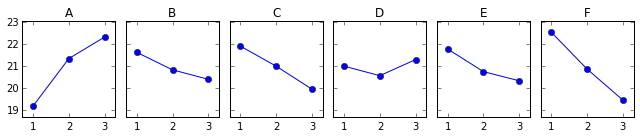

In [5]:
SNave = pd.DataFrame.copy(SNsum)/6
print "\n標準SN比の水準別平均\n",SNave
plotEffect(SNave)

最適条件はA3B1C1D3E1F1である(なお最適条件のSN比の計算にはABCEFを使う。つまりDは使わない）

In [6]:
ave = SNsum.sum(1)[0]/18
eta_opt = SNave.ix["A","3"]+SNave.ix["B","1"]+SNave.ix["C","1"]+SNave.ix["E","1"]+SNave.ix["F","1"]-4*ave
eta_ini = SNave.ix["A","2"]+SNave.ix["B","2"]+SNave.ix["C","2"]+SNave.ix["E","2"]+SNave.ix["F","2"]-4*ave
eta_diff = eta_opt-eta_ini
print "最適条件のSN比は、%.1f(db)"%eta_opt
print "現行条件のSN比は、%.1f(db)"%eta_ini
print "\n利得は、%.1f(db)。真数に直すと、%.2f。"%(eta_diff, 10**(eta_diff/10))

最適条件のSN比は、26.4(db)
現行条件のSN比は、21.0(db)

利得は、5.4(db)。真数に直すと、3.48。


###2) 最適条件と現行条件の$\beta_1, \beta_2$を推定せよ。

#### $\beta_1$の推定

In [7]:
B1sum = pd.DataFrame([[12.39,11.12,10.86],
                      [10.15,11.25,12.97],
                      [10.29,11.30,12.78],
                      [11.53,11.34,11.49],
                      [10.63,11.45,12.29],
                      [11.12,11.35,11.90]],
                     index=list("ABCDEF"),
                     columns=["1","2","3"])
print "\n¥beta1の水準別合計\n",B1sum


¥beta1の水準別合計
       1      2      3
A  12.39  11.12  10.86
B  10.15  11.25  12.97
C  10.29  11.30  12.78
D  11.53  11.34  11.49
E  10.63  11.45  12.29
F  11.12  11.35  11.90



¥beta1の水準別平均
        1       2       3
A  2.0650  1.8533  1.8100
B  1.6917  1.8750  2.1617
C  1.7150  1.8833  2.1300
D  1.9217  1.8900  1.9150
E  1.7717  1.9083  2.0483
F  1.8533  1.8917  1.9833

効果図


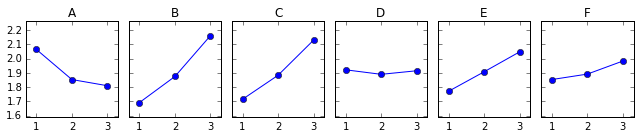

In [8]:
B1ave = pd.DataFrame.copy(B1sum)/6
print "\n¥beta1の水準別平均\n",B1ave
plotEffect(B1ave,margin=0.1)

(1)より最適条件はA3B1C1D3E1F1であるが、$\beta_1$の計算にはABCEを使う。つまりDFは使わない。

In [9]:
ave = B1sum.sum(1)[0]/18
beta1_opt = B1ave.ix["A","3"]+B1ave.ix["B","1"]+B1ave.ix["C","1"]+B1ave.ix["E","1"]-3*ave
beta1_ini = B1ave.ix["A","2"]+B1ave.ix["B","2"]+B1ave.ix["C","2"]+B1ave.ix["E","2"]-3*ave
beta1_diff = beta1_opt-beta1_ini
print "最適条件の¥beta1は、%.2f"%beta1_opt
print "現行条件の¥beta1は、%.2f"%beta1_ini

最適条件の¥beta1は、1.26
現行条件の¥beta1は、1.79


#### $\beta_2$の推定

In [10]:
B2sum = pd.DataFrame([[-0.155,-0.123,-0.104],
                      [-0.111,-0.137,-0.134],
                      [-0.112,-0.133,-0.138],
                      [-0.123,-0.132,-0.128],
                      [-0.126,-0.128,-0.128],
                      [-0.106,-0.135,-0.141]],
                     index=list("ABCDEF"),
                     columns=["1","2","3"])
print "\n¥beta2の水準別合計\n",B2sum


¥beta2の水準別合計
       1      2      3
A -0.155 -0.123 -0.104
B -0.111 -0.137 -0.134
C -0.112 -0.133 -0.138
D -0.123 -0.132 -0.128
E -0.126 -0.128 -0.128
F -0.106 -0.135 -0.141



¥beta2の水準別平均
        1       2       3
A -0.0258 -0.0205 -0.0173
B -0.0185 -0.0228 -0.0223
C -0.0187 -0.0222 -0.0230
D -0.0205 -0.0220 -0.0213
E -0.0210 -0.0213 -0.0213
F -0.0177 -0.0225 -0.0235

効果図


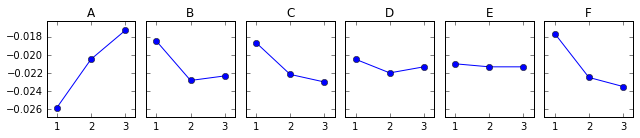

In [11]:
B2ave = pd.DataFrame.copy(B2sum)/6
print "\n¥beta2の水準別平均\n",B2ave
plotEffect(B2ave,margin=0.001)

(1)より最適条件はA3B1C1D3E1F1であるが、$\beta_2$の計算にはAFを使う。つまりBCDEは使わない。

In [12]:
ave = B2sum.sum(1)[0]/18
beta2_opt = B2ave.ix["A","3"]+B2ave.ix["F","1"]-ave
beta2_ini = B2ave.ix["A","2"]+B2ave.ix["F","2"]-ave
beta2_diff = beta2_opt-beta2_ini
print "最適条件の¥beta2は、%.4f"%beta2_opt
print "現行条件の¥beta2は、%.4f"%beta2_ini

最適条件の¥beta2は、-0.0138
現行条件の¥beta2は、-0.0218


###3)最適条件と初期条件について確認計算を行い、次のデータを得た。<br>2乗和の分解を行い、標準SN比および$\beta_1$を求め、結果を表にまとめ、再現性について検討せよ。

#### 2乗和分解

In [13]:
opt = pd.DataFrame([[11.0,64.3,73.5],
                    [8.8,68.7,64.6],
                    [12.7,63.3,78.5]],
                    index=["N0","N1","N2"],
                    columns=["M1","M2","M3"])
print "\n確認データ(mV) @最適条件\n",opt
ini = pd.DataFrame([[62.8,101.5,107.3],
                    [49.8,90.3,98.5],
                    [96.8,129.5,139.3]],
                    index=["N0","N1","N2"],
                    columns=["M1","M2","M3"])
print "\n確認データ(mV) @現行条件\n",ini


確認データ(mV) @最適条件
      M1    M2    M3
N0  11.0  64.3  73.5
N1   8.8  68.7  64.6
N2  12.7  63.3  78.5

確認データ(mV) @現行条件
      M1     M2     M3
N0  62.8  101.5  107.3
N1  49.8   90.3   98.5
N2  96.8  129.5  139.3


In [14]:
print "最適条件の2乗和分解表"
dynamicProp(opt.ix[0,:],opt.ix[1:,:])  

最適条件の2乗和分解表
     F           S           V
b    1  19168.6999  19168.6999
N*b  1     26.6399     26.6399
e    4    105.3802     26.3450
(N)  5    132.0201     26.4040
T    6  19300.7200         NaN


In [15]:
print "現行条件の2乗和分解表"
dynamicProp(ini.ix[0,:],ini.ix[1:,:])  

現行条件の2乗和分解表
     F           S           V
b    1  63135.5008  63135.5008
N*b  1   2482.1306   2482.1306
e    4    263.7286     65.9322
(N)  5   2745.8592    549.1718
T    6  65881.3600         NaN


#### 標準SN比

In [16]:
eta_opt_check = dynamicProp(opt.ix[0,:],opt.ix[1:,:], calcStandardSN=True)
print "最適条件の標準SN比は、%.2f(db)"%eta_opt_check

最適条件の標準SN比は、28.60(db)


In [17]:
eta_ini_check = dynamicProp(ini.ix[0,:],ini.ix[1:,:], calcStandardSN=True)
print "現行条件の標準SN比は、%.2f(db)"%eta_ini_check

現行条件の標準SN比は、20.60(db)


In [18]:
eta_diff_check = eta_opt_check - eta_ini_check
print "利得は、%.1f(db)。真数に直すと、%.2f。"%(eta_diff_check, 10**(eta_diff_check/10))

利得は、8.0(db)。真数に直すと、6.31。


#### $\beta_1$

In [19]:
# 目標値
m = np.asarray([0,50,67]) 
# 標準条件の出力
y_opt = opt.ix[0,:]
y_ini = ini.ix[0,:]
# beta1 = L1/r1 <-eq(8.15)
beta1_opt_check = m.dot(y_opt)/(m*m).sum()
beta1_ini_check = m.dot(y_ini)/(m*m).sum()
beta1_diff_check = beta1_opt_check - beta1_ini_check
print "最適条件のbeta1は、%.2f"%beta1_opt_check
print "現行条件のbeta1は、%.2f"%beta1_ini_check
print "差は、%.2f。"%beta1_diff_check

最適条件のbeta1は、1.16
現行条件のbeta1は、1.75
差は、-0.59。


#### 表にまとめる

In [20]:
pd.set_option('display.precision', 3)
summary = pd.DataFrame([["opt","ini","diff",
                         "opt","ini","diff",
                         "opt","ini","diff"],
                        [eta_opt,eta_ini,eta_diff,
                         beta1_opt,beta1_ini,beta1_diff,
                         beta2_opt,beta2_ini,beta2_diff],
                        [eta_opt_check,eta_ini_check,eta_diff_check,
                         beta1_opt_check,beta1_ini_check,beta1_diff_check,
                         -0.011,-0.025,0.014]],
                        index=["","推定","確認"],
                        columns=["SN比(db)","","",
                                "beta1","","",
                                "beta2","",""])
print summary

   SN比(db)             beta1                beta2               
       opt   ini  diff   opt   ini   diff     opt     ini   diff
推定    26.4    21  5.42  1.26  1.79 -0.532 -0.0138 -0.0218  0.008
確認    28.6  20.6     8  1.16  1.75  -0.59  -0.011  -0.025  0.014


#### 再現性について検討

大小関係だけでなく、絶対値もよく再現している。

* SN比に関しては、確認実験で推定よりもよい結果(SN比が大きい)を得た。
* beta1に関しても、確認実験で推定よりもよい結果(beta1が1に近い)を得た。
* beta2に関しても、確認実験で推定よりもよい結果(beta2が0に近い)を得た。

In [21]:
%load_ext version_information
%version_information numpy, matplotlib, pandas, ipython, version_information

Software versions
Python 2.7.9 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.56)]
IPython 3.0.0-dev
OS Darwin 14.4.0 x86_64 i386 64bit
numpy 1.10.0.dev+a02f5c8
matplotlib 1.4.2
pandas 0.16.0
ipython 3.0.0.dev0
version_information 1.0.3
Sun Jul 26 17:23:52 2015 JST